# Clustering on a credit card data set

### Grouping our customers according to their purchase behaviors using K-means

In [89]:
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [94]:
data = pd.read_csv('CC GENERAL.csv', ',')
data = data.drop(columns='CUST_ID')
data = data.fillna(0)

Let's do a quick PCA analysis of our data

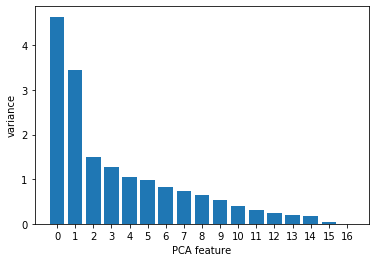

In [95]:
# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to 'samples'
pipeline.fit(data)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [96]:
dataframe = data.loc[:,['PURCHASES_TRX', 'PURCHASES', 'PURCHASES_FREQUENCY']]
print(dataframe.head())

   PURCHASES_TRX  PURCHASES  PURCHASES_FREQUENCY
0              2      95.40             0.166667
1              0       0.00             0.000000
2             12     773.17             1.000000
3              1    1499.00             0.083333
4              1      16.00             0.083333


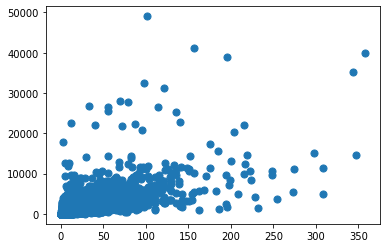

In [63]:
dataframe = dataframe.to_numpy()
plot1 = plt.scatter(dataframe[:, 0], dataframe[:, 1], s=50)
plt.show(plot1)

### Calculating the optimal number of clusters with the elbow method

 Inertia: the sum of squared distances of samples to their closest cluster center

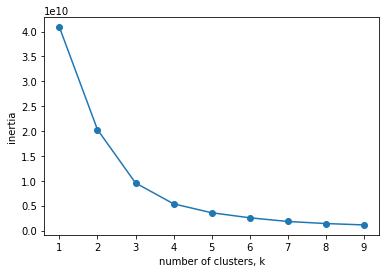

In [64]:
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k)
    
    # Fit model to samples
    model.fit(dataframe)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

From our graph we see that the inflection point is at three or four clusters. We will use four cluster for our analysis.

In [65]:
# creating the clusters
kmeans = KMeans(n_clusters=4, random_state=30).fit(dataframe)

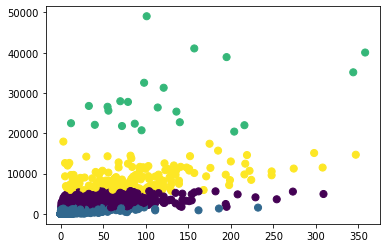

In [66]:
# plotting the results, x = the number of purchase transactions, y = the amount of purchases
plot_result_kmeans = plt.scatter(dataframe[:, 0], dataframe[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
plt.show(plot_result_kmeans)

Now, we can check the statistics of each clusters : number of customers, mean purchase amount, mean purchase frequency, and mean number of purchases

In [67]:
# to do that, we need to convert our numpy array back to a dataframe to add the CUST_ID column
# and group our customers by clusters
result_df_kmeans = pd.DataFrame(kmeans.labels_)

final_df_kmeans = pd.DataFrame(dataframe)
final_df_kmeans['CUST_ID'] = data['CUST_ID']

final_df_kmeans = pd.merge(final_df_kmeans, result_df_kmeans, left_index=True, right_index=True)
final_df_kmeans = final_df_kmeans.rename(columns={'0_y': 'clusters', 1: 'PURCHASES', 2: 'PURCHASES_FREQUENCY', '0_x': 'PURCHASE_TRX'})
final_df_kmeans = final_df_kmeans.groupby('clusters').agg({'CUST_ID': 'count',
                                                           'PURCHASES': 'mean',
                                            'PURCHASES_FREQUENCY': 'mean',
                                            'PURCHASE_TRX': 'mean',
                                            })

print(final_df_kmeans.head())

          CUST_ID     PURCHASES  PURCHASES_FREQUENCY  PURCHASE_TRX
clusters                                                          
0            1349   2838.447702             0.864529     39.124537
1            7376    379.641932             0.408646      7.847614
2              22  28601.207727             0.915909    126.500000
3             203   8473.654433             0.926444     89.689655


Cluster 1 : large group of low spenders (80%)

Cluster 2 : very small group of high spenders (0,25%)

### Grouping our customers according to their purchase behaviors using hierarchical agglomerative clustering
##### Ward linkage function

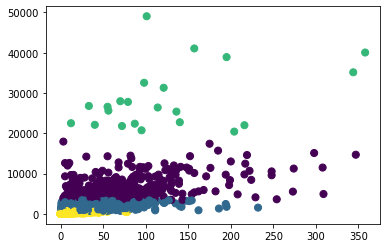

In [68]:
# creating the clusters
hierarchical_clusters = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')
# save clusters and plotting the results
result_hc = hierarchical_clusters.fit_predict(dataframe)
plot_result_hc = plt.scatter(dataframe[:, 0], dataframe[:, 1], c=result_hc, s=50, cmap='viridis')
plt.show(plot_result_hc)

Again, checking the composition of our clusters

In [69]:
result_df_hc = pd.DataFrame(result_hc)
final_df_hc = pd.DataFrame(dataframe)
final_df_hc['CUST_ID'] = data['CUST_ID']

final_df_hc = pd.merge(final_df_hc, result_df_hc, left_index=True, right_index=True)
final_df_hc = final_df_hc.rename(columns={'0_y': 'clusters', 1: 'PURCHASES', 2: 'PURCHASES_FREQUENCY', '0_x': 'PURCHASE_TRX'})

final_df_hc = final_df_hc.groupby('clusters').agg({'CUST_ID': 'count',
                                                   'PURCHASES': 'mean',
                                            'PURCHASES_FREQUENCY': 'mean',
                                            'PURCHASE_TRX': 'mean'})


print(final_df_hc.head())

          CUST_ID     PURCHASES  PURCHASES_FREQUENCY  PURCHASE_TRX
clusters                                                          
0             545   5888.301009             0.920380     68.133945
1            2543   1578.462371             0.768051     24.412112
2              22  28601.207727             0.915909    126.500000
3            5840    192.860074             0.327693      5.078253


Again, we have the same very small group of high spender (0,25%) in cluster 2. Even if it's small, these people are very relevant to the bank as they represent a way higher amount of purchases

However, we have a new cluster (cluster 1) of average/low spenders representing around 30% of our population

We also tried using other linkage functions, which appear to yield nothing useful

##### Single linkage function

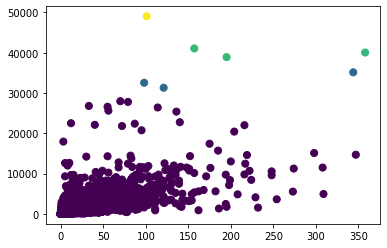

In [76]:
# creating the clusters
hierarchical_clusters = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'single')
# save clusters and plotting the results
result_hc = hierarchical_clusters.fit_predict(dataframe)
plot_result_hc = plt.scatter(dataframe[:, 0], dataframe[:, 1], c=result_hc, s=50, cmap='viridis')
plt.show(plot_result_hc)

Doesn't appear to yield any useful clusters

##### Complete & average linkage functions

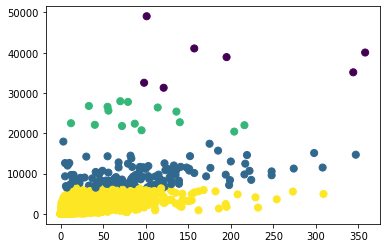

In [77]:
# creating the clusters
hierarchical_clusters = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'complete')
# save clusters and plotting the results
result_hc = hierarchical_clusters.fit_predict(dataframe)
plot_result_hc = plt.scatter(dataframe[:, 0], dataframe[:, 1], c=result_hc, s=50, cmap='viridis')
plt.show(plot_result_hc)

This one might actually be useful, let's check the composition of our clusters

In [78]:
result_df_hc = pd.DataFrame(result_hc)
final_df_hc = pd.DataFrame(dataframe)
final_df_hc['CUST_ID'] = data['CUST_ID']

final_df_hc = pd.merge(final_df_hc, result_df_hc, left_index=True, right_index=True)
final_df_hc = final_df_hc.rename(columns={'0_y': 'clusters', 1: 'PURCHASES', 2: 'PURCHASES_FREQUENCY', '0_x': 'PURCHASE_TRX'})

final_df_hc = final_df_hc.groupby('clusters').agg({'CUST_ID': 'count',
                                                   'PURCHASES': 'mean',
                                            'PURCHASES_FREQUENCY': 'mean',
                                            'PURCHASE_TRX': 'mean'})


print(final_df_hc.head())

          CUST_ID     PURCHASES  PURCHASES_FREQUENCY  PURCHASE_TRX
clusters                                                          
0               7  38286.240000             0.976190    196.285714
1             152   9312.106053             0.921501     94.572368
2              15  24081.526000             0.887778     93.933333
3            8776    790.111277             0.481816     13.046376


It yields something very different but which might be useful

Our original cluster of high spenders representing 0.25% of our population is now splitted in two, but is still relevant due to their higher spending

The cluster representing the low spender now contains 97.5% of our population

Basically, this clustering would be useful to isolate the higher spenders from the rest

## Using standardized data 
### HC with a complete linkage

In [80]:
min_max_scaler = preprocessing.MinMaxScaler()
dataframe_std = min_max_scaler.fit_transform(dataframe)

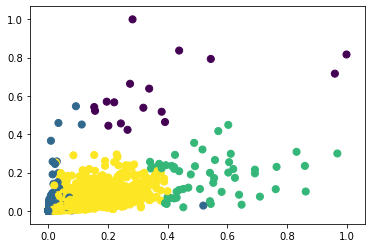

In [81]:
# creating the clusters
hierarchical_clusters_std = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'complete')
# save clusters and plotting the results
result_hc_std = hierarchical_clusters_std.fit_predict(dataframe_std)
plot_result_hc_std = plt.scatter(dataframe_std[:, 0], dataframe_std[:, 1], c=result_hc_std, s=50, cmap='viridis')
plt.show(plot_result_hc_std)

In [82]:
# checking the composition of our clusters
result_df_hc_std = pd.DataFrame(result_hc_std)
final_df_hc_std = pd.DataFrame(dataframe_std)
final_df_hc_std['CUST_ID'] = data['CUST_ID']

final_df_hc_std = pd.merge(final_df_hc_std, result_df_hc_std, left_index=True, right_index=True)
final_df_hc_std = final_df_hc_std.rename(columns={'0_y': 'clusters', 1: 'PURCHASES', 2: 'PURCHASES_FREQUENCY', '0_x': 'PURCHASE_TRX'})

final_df_hc_std = final_df_hc_std.groupby('clusters').agg({'CUST_ID': 'count',
                                                   'PURCHASES': 'mean',
                                            'PURCHASES_FREQUENCY': 'mean',
                                            'PURCHASE_TRX': 'mean'})


print(final_df_hc_std.head())

          CUST_ID  PURCHASES  PURCHASES_FREQUENCY  PURCHASE_TRX
clusters                                                       
0              17   0.618239             0.984314      0.374302
1            5436   0.007402             0.202595      0.010492
2              53   0.179480             0.985849      0.536313
3            3444   0.035665             0.934480      0.080117


We actually get something pretty similar to the hc with ward linkage, and which makes sense!

Again, we have a new cluster (cluster 3) of average/low spenders, now representing around 40% of our population

### K-means

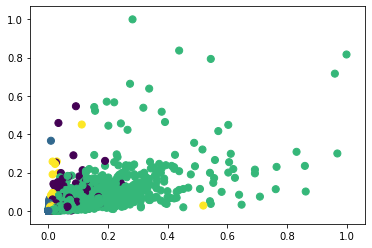

In [85]:
kmeans_std = KMeans(n_clusters=4, random_state=30).fit(dataframe_std)
plot_result_std = plt.scatter(dataframe_std[:, 0], dataframe_std[:, 1], c=kmeans_std.labels_, s=50, cmap='viridis')
plt.show(plot_result_std)

It looks pretty messy at first, but looking at our clusters' information, we again have something useful and different from before

In [86]:
# reworking the results
result_df_kmeans_std = pd.DataFrame(kmeans_std.labels_)
final_df_kmeans_std = pd.DataFrame(dataframe_std)
final_df_kmeans_std['CUST_ID'] = data['CUST_ID']
final_df_kmeans_std = pd.merge(final_df_kmeans_std, result_df_kmeans_std, left_index=True, right_index=True)
final_df_kmeans_std = final_df_kmeans_std.rename(columns={'0_y': 'clusters', 1: 'PURCHASES', 2: 'PURCHASES_FREQUENCY', '0_x': 'PURCHASE_TRX'})
final_df_kmeans_std = final_df_kmeans_std.groupby('clusters').agg({'CUST_ID': 'count', 'PURCHASES': 'mean',
                                            'PURCHASES_FREQUENCY': 'mean',
                                            'PURCHASE_TRX': 'mean'
                                            })

print(final_df_kmeans_std.head())

          CUST_ID  PURCHASES  PURCHASES_FREQUENCY  PURCHASE_TRX
clusters                                                       
0            1443   0.021648             0.617466      0.037374
1            3274   0.002425             0.043061      0.002026
2            3099   0.041734             0.962928      0.092681
3            1134   0.012858             0.328515      0.017605


Our groups are now much more balanced in terms of proportion of the population

We have two clusters representing each 30-35% of the population, one of high volume and frequent spenders (cluster 2), and another one of low volume and rare spenders (cluster 1)